<a href="https://colab.research.google.com/github/sgevatschnaider/IA-Teoria-Practica/blob/main/notebooks/Ejemplos_validacion_cruzada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PASO 1: Carga y división de datos
Dataset: .. _breast_cancer_dataset:
Tamaño total: 569 muestras, 30 features
Train: 455  |  Test: 114
------------------------------------------------------------
PASO 2: Esquema de Validación Cruzada (5-fold)
Mostrando cómo StratifiedKFold divide los datos de entrenamiento...


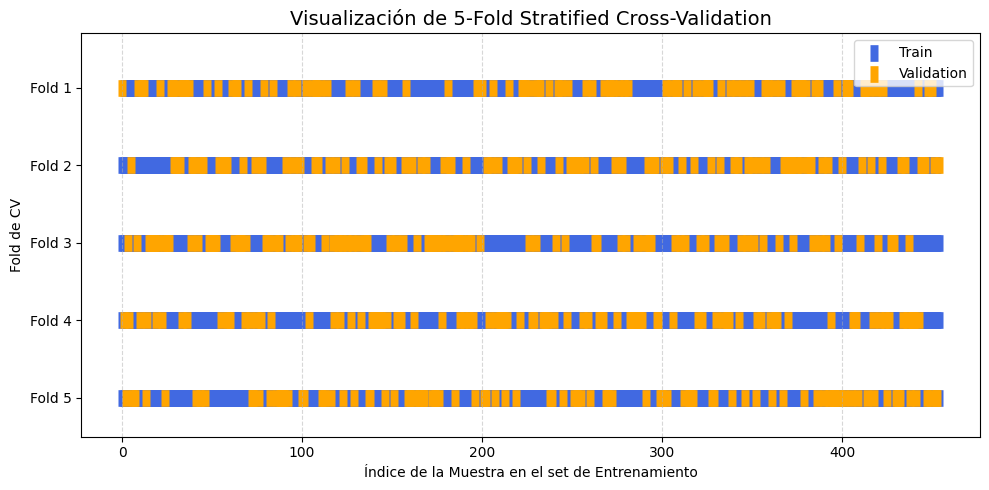

------------------------------------------------------------
PASO 3: Rendimiento de línea base (árbol sin control)
Baseline (sin max_depth):
  Accuracy CV (media ± std): 0.9165 ± 0.0179
  (Este árbol probablemente sufre de overfitting)
------------------------------------------------------------
PASO 4: Analizar el efecto de 'max_depth' con una Curva de Validación
Resultados de la Curva de Validación:
  max_depth= 1 | train_acc=0.9258 | val_acc=0.9033
  max_depth= 2 | train_acc=0.9615 | val_acc=0.9319
  max_depth= 3 | train_acc=0.9791 | val_acc=0.9253
  max_depth= 4 | train_acc=0.9879 | val_acc=0.9297
  max_depth= 5 | train_acc=0.9923 | val_acc=0.9231
  max_depth= 6 | train_acc=0.9973 | val_acc=0.9253
  max_depth= 7 | train_acc=0.9984 | val_acc=0.9231
  max_depth= 8 | train_acc=0.9995 | val_acc=0.9231
  max_depth= 9 | train_acc=1.0000 | val_acc=0.9165
  max_depth=10 | train_acc=1.0000 | val_acc=0.9165
  max_depth=11 | train_acc=1.0000 | val_acc=0.9165
  max_depth=12 | train_acc=1.0000 

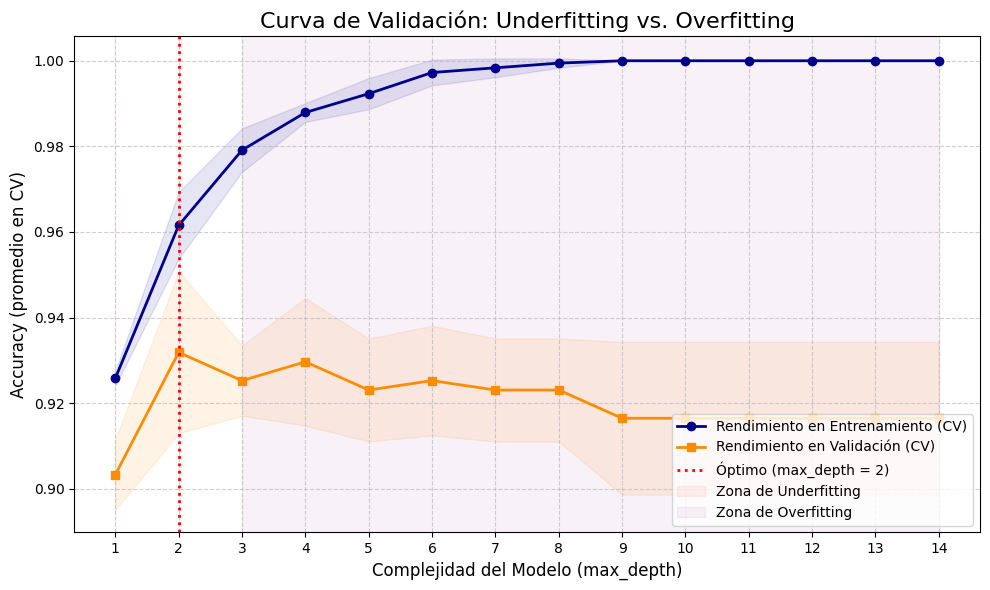

PASO 5: Usar GridSearchCV para automatizar la búsqueda del mejor 'max_depth'
Resultados de GridSearchCV:
  Mejor parámetro encontrado: {'max_depth': np.int64(2)}
  Mejor accuracy promedio en CV: 0.9319
  (Confirma el valor 2 encontrado con la curva de validación)
------------------------------------------------------------
PASO 6: Visualizar los árboles para entender el impacto de 'max_depth'


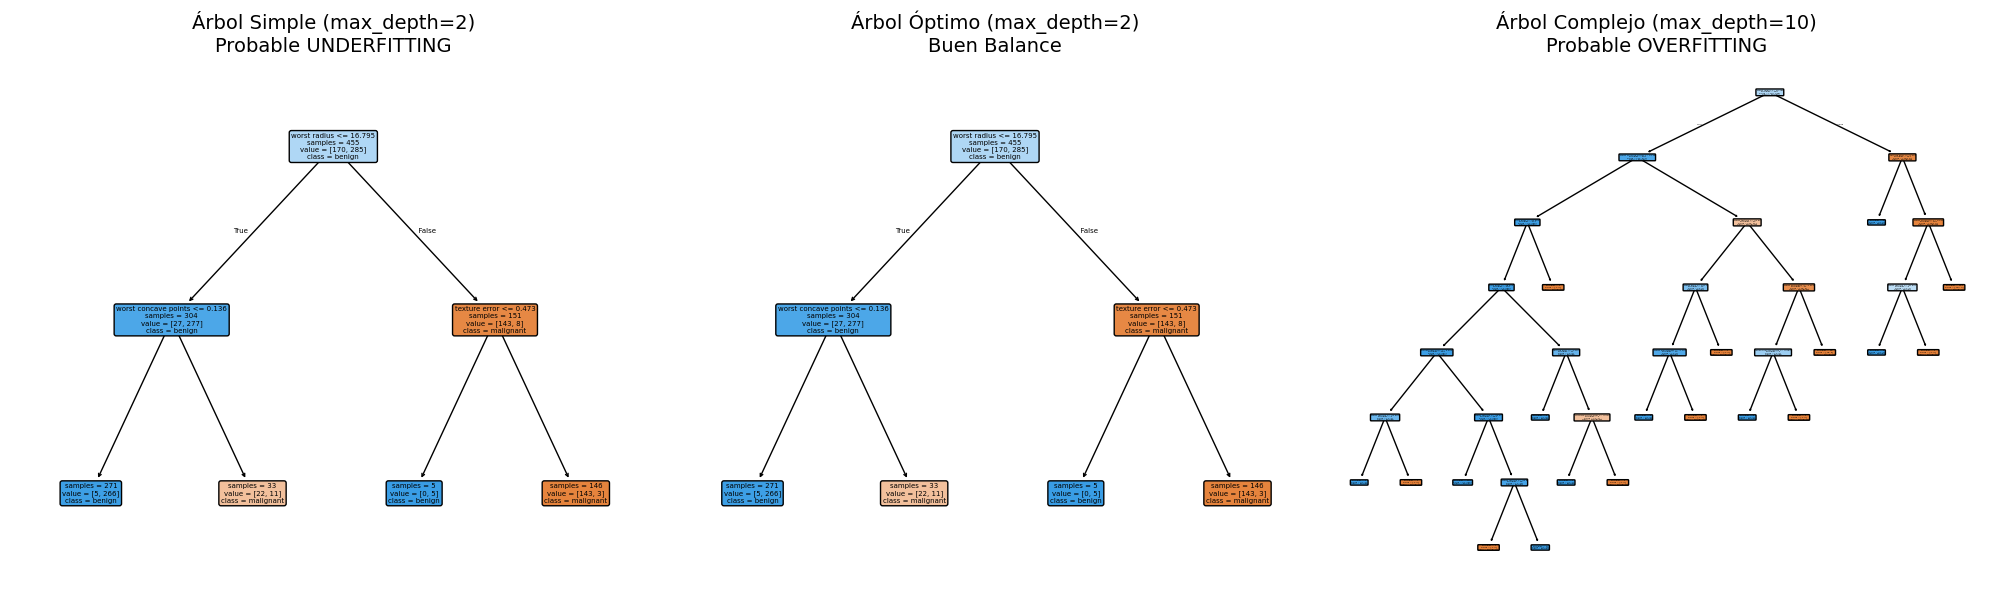

------------------------------------------------------------
PASO 7: Evaluación final en el conjunto de TEST con max_depth=2
(Usamos el conjunto de Test, que el modelo NUNCA ha visto antes)

  Accuracy en Test: 0.8947

  Reporte de Clasificación (Test):
              precision    recall  f1-score   support

   malignant       0.80      0.95      0.87        42
      benign       0.97      0.86      0.91        72

    accuracy                           0.89       114
   macro avg       0.88      0.91      0.89       114
weighted avg       0.91      0.89      0.90       114

  Matriz de Confusión (Test):
[[40  2]
 [10 62]]
------------------------------------------------------------
CONCLUSIONES DIDÁCTICAS FINALES:
1. Visualizamos la CV para entender cómo se parte el set de entrenamiento.
2. La curva de validación nos mostró el 'punto dulce' para max_depth, evitando underfitting y overfitting.
3. Visualizamos los árboles y vimos que un árbol simple es poco útil y uno complejo se vuelve 

In [ ]:
# =================================================================================
# Script Avanzado: Validación Cruzada para Árboles de Decisión con Visualizaciones
# Autor: Sergio Gevatschnaider| Propósito: Script didáctico para clases
# Requisitos: scikit-learn, numpy, matplotlib, graphviz
# Nota: Para visualizar los árboles, podrías necesitar instalar graphviz:
#       pip install graphviz
#       Y también instalar el software de Graphviz en tu sistema operativo.
# =================================================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    validation_curve,
    GridSearchCV
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Función Auxiliar para Visualizar Splits de CV ---
def plot_cv_splits(cv, X, y, n_splits):
    """Visualiza las divisiones de entrenamiento/validación de StratifiedKFold."""
    fig, ax = plt.subplots(figsize=(10, 5))

    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Rellenar indices de entrenamiento
        ax.scatter(train_idx, [i + 0.5] * len(train_idx),
                   color='royalblue', marker='_', lw=12, label="Train" if i == 0 else "")
        # Rellenar indices de validación
        ax.scatter(val_idx, [i + 0.5] * len(val_idx),
                   color='orange', marker='_', lw=12, label="Validation" if i == 0 else "")

    # Formateo del gráfico
    ax.set_title(f'Visualización de {n_splits}-Fold Stratified Cross-Validation', fontsize=14)
    ax.set_xlabel('Índice de la Muestra en el set de Entrenamiento')
    ax.set_ylabel('Fold de CV')
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels([f'Fold {i+1}' for i in range(n_splits)])
    ax.set_ylim(n_splits, -0.2)
    ax.legend(loc='upper right')
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ================================================================
# 1) Cargar datos y separar Test
# ================================================================
print("PASO 1: Carga y división de datos")
data = load_breast_cancer()
X, y = data.data, data.target

# Mantener proporciones de clases en train/test (estratificación)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print(f"Dataset: {data.DESCR.splitlines()[0]}")
print(f"Tamaño total: {X.shape[0]} muestras, {X.shape[1]} features")
print(f"Train: {X_train.shape[0]}  |  Test: {X_test.shape[0]}")
print("-" * 60)

# ================================================================
# 2) Definir y VISUALIZAR el esquema de Validación Cruzada
# ================================================================
print("PASO 2: Esquema de Validación Cruzada (5-fold)")
N_SPLITS = 5
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# ¡Visualización clave para la clase!
print("Mostrando cómo StratifiedKFold divide los datos de entrenamiento...")
plot_cv_splits(cv, X_train, y_train, N_SPLITS)
print("-" * 60)

# ================================================================
# 3) Línea base: árbol sin limitar profundidad
# ================================================================
print("PASO 3: Rendimiento de línea base (árbol sin control)")
baseline_clf = DecisionTreeClassifier(random_state=42)
baseline_scores = cross_val_score(
    baseline_clf, X_train, y_train,
    cv=cv, scoring="accuracy", n_jobs=-1
)
print("Baseline (sin max_depth):")
print(f"  Accuracy CV (media ± std): {baseline_scores.mean():.4f} ± {baseline_scores.std():.4f}")
print("  (Este árbol probablemente sufre de overfitting)")
print("-" * 60)

# ================================================================
# 4) Validation Curve: score vs. max_depth
# ================================================================
print("PASO 4: Analizar el efecto de 'max_depth' con una Curva de Validación")
depth_range = np.arange(1, 15)  # 1..14 es suficiente para este dataset
train_scores, val_scores = validation_curve(
    estimator=DecisionTreeClassifier(random_state=42),
    X=X_train, y=y_train,
    param_name="max_depth",
    param_range=depth_range,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

best_depth_vc = depth_range[np.argmax(val_mean)]
print("Resultados de la Curva de Validación:")
for d, tr, va in zip(depth_range, train_mean, val_mean):
    print(f"  max_depth={d:>2} | train_acc={tr:.4f} | val_acc={va:.4f}")
print(f"\n>>> Mejor 'max_depth' según la curva de validación: {best_depth_vc}")
print("-" * 60)

# Gráfico mejorado de la curva de validación
plt.figure(figsize=(10, 6))
plt.title("Curva de Validación: Underfitting vs. Overfitting", fontsize=16)
plt.xlabel("Complejidad del Modelo (max_depth)", fontsize=12)
plt.ylabel("Accuracy (promedio en CV)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(depth_range)

# Curva de entrenamiento
plt.plot(depth_range, train_mean, 'o-', color="darkblue", lw=2, label="Rendimiento en Entrenamiento (CV)")
plt.fill_between(depth_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color="darkblue")

# Curva de validación
plt.plot(depth_range, val_mean, 's-', color="darkorange", lw=2, label="Rendimiento en Validación (CV)")
plt.fill_between(depth_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color="darkorange")

# Marcar el mejor punto y las zonas
plt.axvline(best_depth_vc, linestyle=":", color="red", lw=2, label=f"Óptimo (max_depth = {best_depth_vc})")
plt.axvspan(1, best_depth_vc - 1, color='red', alpha=0.05, label='Zona de Underfitting')
plt.axvspan(best_depth_vc + 1, depth_range[-1], color='purple', alpha=0.05, label='Zona de Overfitting')

plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()

# ================================================================
# 5) GridSearchCV: confirmar y seleccionar mejor max_depth
# ================================================================
print("PASO 5: Usar GridSearchCV para automatizar la búsqueda del mejor 'max_depth'")
param_grid = {"max_depth": list(depth_range)}
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_depth_grid = grid.best_params_['max_depth']
print("Resultados de GridSearchCV:")
print(f"  Mejor parámetro encontrado: {grid.best_params_}")
print(f"  Mejor accuracy promedio en CV: {grid.best_score_:.4f}")
print(f"  (Confirma el valor {best_depth_grid} encontrado con la curva de validación)")
print("-" * 60)


# ================================================================
# 6) Visualización de Árboles: Underfit, Óptimo y Overfit
# ================================================================
print(f"PASO 6: Visualizar los árboles para entender el impacto de 'max_depth'")

# Árbol con underfitting (muy simple)
underfit_tree = DecisionTreeClassifier(max_depth=2, random_state=42).fit(X_train, y_train)

# Árbol óptimo
optimal_tree = grid.best_estimator_

# Árbol con overfitting (muy complejo)
overfit_tree = DecisionTreeClassifier(max_depth=10, random_state=42).fit(X_train, y_train)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Dibujar árbol underfit
plot_tree(underfit_tree,
          ax=axes[0],
          feature_names=data.feature_names,
          class_names=data.target_names,
          filled=True, rounded=True, impurity=False)
axes[0].set_title("Árbol Simple (max_depth=2)\nProbable UNDERFITTING", fontsize=14)

# Dibujar árbol óptimo
plot_tree(optimal_tree,
          ax=axes[1],
          feature_names=data.feature_names,
          class_names=data.target_names,
          filled=True, rounded=True, impurity=False)
axes[1].set_title(f"Árbol Óptimo (max_depth={best_depth_grid})\nBuen Balance", fontsize=14)

# Dibujar árbol overfit
plot_tree(overfit_tree,
          ax=axes[2],
          feature_names=data.feature_names,
          class_names=data.target_names,
          filled=True, rounded=True, impurity=False)
axes[2].set_title("Árbol Complejo (max_depth=10)\nProbable OVERFITTING", fontsize=14)

plt.tight_layout()
plt.show()
print("-" * 60)


# ================================================================
# 7) Evaluar en Test (el paso final y crucial)
# ================================================================
print(f"PASO 7: Evaluación final en el conjunto de TEST con max_depth={best_depth_grid}")
print("(Usamos el conjunto de Test, que el modelo NUNCA ha visto antes)")

# El `grid` ya re-entrenó el mejor modelo en todo X_train, así que podemos usar `grid.predict`
y_pred_test = grid.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"\n  Accuracy en Test: {test_acc:.4f}")
print("\n  Reporte de Clasificación (Test):")
print(classification_report(y_test, y_pred_test, target_names=data.target_names))

print("  Matriz de Confusión (Test):")
print(confusion_matrix(y_test, y_pred_test))
print("-" * 60)

# ================================================================
# 8) Conclusiones Didácticas
# ================================================================
print("CONCLUSIONES DIDÁCTICAS FINALES:")
print("1. Visualizamos la CV para entender cómo se parte el set de entrenamiento.")
print("2. La curva de validación nos mostró el 'punto dulce' para max_depth, evitando underfitting y overfitting.")
print("3. Visualizamos los árboles y vimos que un árbol simple es poco útil y uno complejo se vuelve ilegible y poco generalizable.")
print("4. Elegimos el hiperparámetro que mejor funcionó en PROMEDIO durante la validación cruzada.")
print("5. La evaluación final en el conjunto de TEST nos da una estimación realista de cómo funcionará el modelo en el futuro con datos nuevos.")


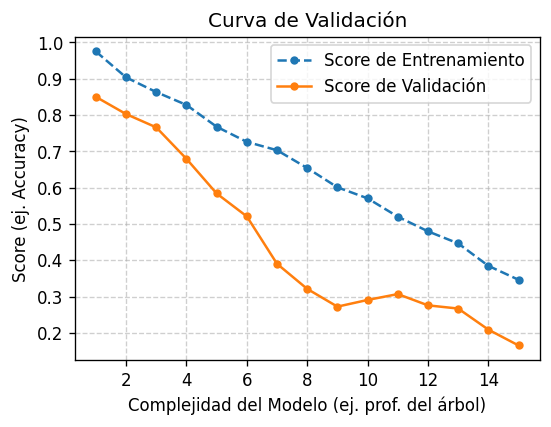
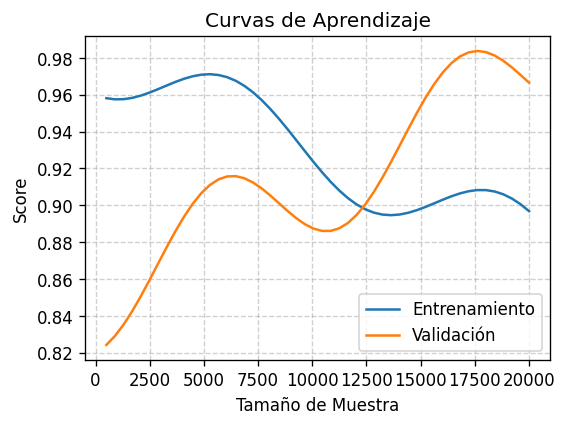

In [ ]:
# This cell builds an interactive HTML page (for Google Colab / Jupyter) that
# explains "Validación en Machine Learning", now including a detailed, animated
# visualizer for the Grid Search CV process. It includes:
# - Theme toggle (light/dark)
# - Animated bubble background
# - Collapsible sections + sticky index
# - MathJax for formulas
# - Illustrative charts generated with matplotlib
# - Interactive sliders and a new Grid Search simulation
#
# The result is also saved as an .html file for download.

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import io, base64, os

# -------------------- Utilities --------------------
def fig_to_base64(dpi=120):
    """Encode current Matplotlib figure to base64 PNG and close the figure."""
    buf = io.BytesIO()
    plt.savefig(buf, format="png", dpi=dpi, bbox_inches="tight")
    plt.close()
    buf.seek(0)
    return base64.b64encode(buf.read()).decode("ascii")

# -------------------- Figure 1: Validation Curve --------------------
np.random.seed(42)
param_range = np.arange(1, 16)
train_scores = 0.96 - 0.04 * param_range + 0.05 / param_range + np.random.normal(0, 0.01, len(param_range))
valid_scores = 0.92 - 0.2 * np.exp(-0.5 * (param_range - 8)**2 / 4) - 0.05 * param_range + np.random.normal(0, 0.015, len(param_range))
train_scores = np.clip(train_scores, 0, 1)
valid_scores = np.clip(valid_scores, 0.1, 0.85)

plt.figure(figsize=(5, 3.5))
plt.plot(param_range, train_scores, label="Score de Entrenamiento", marker='o', markersize=4, linestyle='--')
plt.plot(param_range, valid_scores, label="Score de Validación", marker='o', markersize=4)
plt.xlabel("Complejidad del Modelo (ej. prof. del árbol)")
plt.ylabel("Score (ej. Accuracy)")
plt.title("Curva de Validación")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
img_validation_curve = fig_to_base64()


# -------------------- Figure 2: Learning Curves (samples vs error) --------------------
np.random.seed(0)
n = np.linspace(500, 20000, 50)
train_lc = 0.98 - 0.000005*n - 0.02*np.cos(n/2000)
val_lc   = 0.85 + 0.000006*n - 0.03*np.cos(n/1800)
train_lc = np.clip(train_lc, 0, 1)
val_lc   = np.clip(val_lc, 0, 1)

plt.figure(figsize=(5, 3.5))
plt.plot(n, train_lc, label="Entrenamiento")
plt.plot(n, val_lc,   label="Validación")
plt.xlabel("Tamaño de Muestra")
plt.ylabel("Score")
plt.title("Curvas de Aprendizaje")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
img_learning_curves = fig_to_base64()


# -------------------- Content Blocks --------------------
intro_html = r"""
<p>El objetivo principal en Machine Learning es construir modelos que <strong>generalicen</strong> bien, es decir, que hagan predicciones precisas sobre datos nuevos que no se utilizaron durante el entrenamiento. ¿Pero cómo podemos medir esta capacidad de generalización de manera fiable?</p>
<p>Simplemente evaluar el modelo con los mismos datos con los que fue entrenado es engañoso. Un modelo puede "memorizar" las respuestas del conjunto de entrenamiento y aun así ser inútil en un escenario real. Aquí es donde la <strong>validación</strong> se vuelve fundamental: es el proceso de evaluar el rendimiento del modelo en un conjunto de datos independiente para obtener una estimación imparcial de su desempeño en el mundo real.</p>
"""

traintest_html = r"""
<h4>Definición y Pasos Básicos</h4>
<p>El método más simple de validación es el <em>Train-Test Split</em> (Partición Entrenamiento-Prueba). Consiste en dividir el conjunto de datos disponible en dos subconjuntos.</p>
<ul>
  <li><strong>Conjunto de Entrenamiento (Train Set):</strong> Se utiliza para que el algoritmo de aprendizaje automático "aprenda" los patrones en los datos y ajuste los parámetros internos del modelo.</li>
  <li><strong>Conjunto de Prueba (Test Set):</strong> Se mantiene completamente separado durante el entrenamiento. Una vez que el modelo está entrenado, se utiliza para evaluar su rendimiento en datos "nuevos", proporcionando una estimación de cómo se comportará en producción.</li>
</ul>
<p>Este proceso ayuda a detectar el <strong>sobreajuste (overfitting)</strong>, que ocurre cuando un modelo aprende demasiado bien los datos de entrenamiento (incluido el ruido) y pierde su capacidad de generalizar.</p>
<div class="demo-card">
  <h4>Visualizador de Particiones Train/Val/Test</h4>
  <p>Ajusta los deslizantes; se normalizan automáticamente para sumar 100%. La separación en tres conjuntos (Train/Dev/Test) es una práctica robusta en proyectos grandes.</p>
  <div class="sliders">
    <label>Train <input id="rngTrain" type="range" min="10" max="90" value="70"></label>
    <label>Val <input id="rngVal" type="range" min="5" max="60" value="15"></label>
    <label>Test <input id="rngTest" type="range" min="5" max="60" value="15"></label>
  </div>
  <div class="stacked-bar" aria-label="Barra apilada de particiones">
    <div id="barTrain" class="seg train">Train 70%</div>
    <div id="barVal" class="seg val">Val 15%</div>
    <div id="barTest" class="seg test">Test 15%</div>
  </div>
</div>
"""

cv_motivation_html = r"""
<h4>Motivación y Objetivo</h4>
<p>Una simple partición Train-Test tiene una debilidad: el rendimiento medido puede depender en gran medida de <strong>cómo se realizó la partición al azar</strong>. Si por casualidad en el conjunto de prueba caen ejemplos muy "fáciles" o muy "difíciles", nuestra estimación del rendimiento será demasiado optimista o pesimista.</p>
<p>La <strong>Validación Cruzada (Cross-Validation)</strong> es una técnica que resuelve este problema al realizar múltiples particiones y promediar los resultados. Su objetivo es obtener una medida de rendimiento más robusta y estable, que sea independiente de una única partición aleatoria de los datos. Esto es especialmente útil cuando la cantidad de datos es limitada, ya que nos permite usar todos los datos tanto para entrenamiento como para validación.</p>
"""

kfold_html = r"""
<h4>K-Fold Cross Validation</h4>
<p>Es la técnica de validación cruzada más común. El procedimiento es el siguiente:</p>
<ol>
    <li>Se divide aleatoriamente el conjunto de datos en <strong>K</strong> subconjuntos o "folds" de tamaño aproximadamente igual.</li>
    <li>Se realizan <strong>K</strong> iteraciones. En cada iteración:
        <ul>
            <li>Un "fold" se reserva como conjunto de validación (test).</li>
            <li>Los <strong>K-1</strong> "folds" restantes se utilizan para entrenar el modelo.</li>
        </ul>
    </li>
    <li>Se calcula la métrica de rendimiento (ej. accuracy, MSE) para cada iteración.</li>
    <li>El resultado final es el <strong>promedio y la desviación estándar</strong> de las K métricas obtenidas. Esto nos da no solo una estimación del rendimiento, sino también una idea de su variabilidad.</li>
</ol>
<div class="demo-card">
  <h4>Visualizador de K-Folds</h4>
  <p>Elige \(K\) y observa cómo se alterna el fold de validación en cada iteración.</p>
  <label>Folds (K): <input id="rngK" type="range" min="3" max="10" value="5"></label>
  <div id="cvGrid" class="cv-grid" aria-label="Esquema K-fold"></div>
</div>
"""

# <<< NUEVO BLOQUE DE CONTENIDO PARA GRID SEARCH >>>
gridsearch_html = r"""
<h4>¿Qué es Grid Search?</h4>
<p>Es un método <strong>exhaustivo y sistemático</strong> para elegir los hiperparámetros de un modelo. Se define una rejilla (grid) de valores posibles para cada hiperparámetro, y el algoritmo prueba <strong>todas las combinaciones posibles</strong> usando validación cruzada. La combinación con el mejor desempeño promedio (según una métrica) es la "ganadora".</p>

<h4>¿Cómo funciona? (Paso a Paso)</h4>
<ol>
    <li><b>Elegir el estimador:</b> Por ejemplo, <code>DecisionTreeClassifier</code>.</li>
    <li><b>Definir el grid:</b> Un diccionario con listas de valores a probar. En el visualizador de abajo, simulamos este grid: <br><code>{"max_depth": [2, 4, 6, 8], "min_samples_split": [2, 10, 20]}</code></li>
    <li><b>Elegir el esquema de CV:</b> Usaremos 5-Fold Cross-Validation.</li>
    <li><b>Definir la métrica:</b> Por ejemplo, <code>scoring="accuracy"</code>.</li>
    <li>Para <strong>cada una de las 12 combinaciones</strong> del grid:
        <ul>
            <li>Se entrena y valida el modelo 5 veces (una por cada fold de CV).</li>
            <li>Se calcula el promedio de las 5 puntuaciones obtenidas.</li>
        </ul>
    </li>
    <li>Se selecciona la combinación con el <strong>máximo promedio</strong> de la métrica.</li>
    <li>(Opcional pero usual) Se reentrena el modelo con todo el set de entrenamiento usando esos hiperparámetros óptimos (<code>refit=True</code>).</li>
</ol>

<div class="demo-card">
    <h4>Visualizador del Proceso Grid Search</h4>
    <p>Haz clic en el botón para simular cómo Grid Search prueba cada combinación de hiperparámetros contra cada fold de la validación cruzada. Observa el coste computacional: <strong>4</strong> valores de <code>max_depth</code> × <strong>3</strong> de <code>min_samples_split</code> × <strong>5</strong> Folds = <strong>60</strong> entrenamientos en total.</p>
    <div class="gs-controls">
        <button id="gs-start-btn" class="menu-btn"><i class="fa-solid fa-play"></i> Iniciar Simulación</button>
        <span id="gs-status"></span>
    </div>
    <div class="gs-visualizer">
        <div class="gs-grid-pane">
            <h5 class="pane-title">1. Rejilla de Hiperparámetros</h5>
            <div id="gs-grid-container" class="gs-grid"></div>
        </div>
        <div class="gs-cv-pane">
            <h5 class="pane-title">2. Proceso de 5-Fold CV</h5>
            <div id="gs-cv-container" class="gs-cv-folds"></div>
        </div>
    </div>
</div>

<h4>Coste Computacional</h4>
<p>El número total de modelos entrenados se calcula como:</p>
<p style="text-align:center; font-size: 20px;">\(n_{\text{eval}} = (\prod_{j} |grid_{j}|) \times k\)</p>
<p>Si probás 4 valores de <code>max_depth</code> × 3 de <code>min_samples_split</code> con 5-fold CV ⇒ 4 × 3 × 5 = <strong>60 entrenamientos</strong>.</p>

<h4>Ventajas y Límites</h4>
<ul>
    <li><strong>Ventajas:</strong> Es simple, transparente y determinista. Excelente cuando el espacio de búsqueda es pequeño y discreto.</li>
    <li><strong>Límites:</strong> Explota combinatoriamente si agregas muchos hiperparámetros o valores. Es ineficiente en espacios grandes o continuos, donde convienen alternativas como <code>RandomizedSearchCV</code> o Búsqueda Bayesiana.</li>
</ul>

<h4>Buenas Prácticas Clave</h4>
<ul>
    <li>Encapsula todo el preprocesamiento en un <strong>Pipeline</strong> para evitar la fuga de datos (<em>data leakage</em>).</li>
    <li>Usa <strong>StratifiedKFold</strong> en problemas de clasificación, especialmente con clases desbalanceadas.</li>
    <li>Elige una <strong>métrica de <code>scoring</code></strong> que esté alineada con el objetivo de negocio (ej. F1 o AUC-PR si hay desbalance).</li>
    <li>Para una estimación final sin sesgo optimista, usa <strong>Nested CV</strong> (CV anidada).</li>
    <li>Paraleliza el proceso con <code>n_jobs=-1</code> si tu máquina tiene múltiples núcleos.</li>
</ul>
"""

curves_html = r"""
<p>Las <strong>curvas de validación</strong> son una herramienta de diagnóstico crucial para entender la relación entre un hiperparámetro del modelo y su rendimiento.</p>
<p>Se traza el rendimiento (score) del modelo en los conjuntos de entrenamiento y validación mientras se varía un hiperparámetro, como por ejemplo:</p>
<ul>
    <li>La profundidad máxima de un árbol de decisión.</li>
    <li>El valor de <code>C</code> (regularización) en una SVM.</li>
    <li>El número de vecinos en un modelo KNN.</li>
</ul>
<h4>Diagnóstico de Overfitting y Underfitting</h4>
<p>La forma de estas curvas nos dice mucho sobre el comportamiento del modelo:</p>
<ul>
    <li><strong>Underfitting (Subajuste):</strong> Ocurre cuando tanto el score de entrenamiento como el de validación son bajos. El modelo es demasiado simple para capturar los patrones en los datos.</li>
    <li><strong>Overfitting (Sobreajuste):</strong> Ocurre cuando el score de entrenamiento es muy alto, pero el de validación es significativamente más bajo. El modelo está "memorizando" el entrenamiento y no generaliza.</li>
    <li><strong>Buen Ajuste:</strong> Se busca un punto donde el score de validación es máximo y la diferencia (<em>gap</em>) con el score de entrenamiento es pequeña.</li>
</ul>
<div class="img-wrap">
  <img src="data:image/png;base64,{img_validation_curve}" alt="Curva de validación" loading="lazy" decoding="async" width="520">
  <figcaption>Una curva de validación típica. La zona óptima está donde el score de validación alcanza su máximo.</figcaption>
</div>
"""

sklearn_html = r"""
<p>La biblioteca <strong>Scikit-Learn</strong> es el estándar de oro en Python para Machine Learning y ofrece un módulo muy completo llamado <code>model_selection</code> para todas estas tareas.</p>
<p>Funciones clave incluyen:</p>
<ul>
  <li><code>train_test_split</code>: Para realizar particiones simples de entrenamiento y prueba.</li>
  <li><code>KFold</code>, <code>StratifiedKFold</code>, <code>ShuffleSplit</code>: Generadores para distintos esquemas de validación cruzada.</li>
  <li><code>cross_val_score</code>: Una función de alto nivel que realiza todo el proceso de validación cruzada con una sola llamada.</li>
  <li><code>GridSearchCV</code>, <code>RandomizedSearchCV</code>: Para la búsqueda automática de hiperparámetros.</li>
  <li><code>validation_curve</code>, <code>learning_curve</code>: Funciones para generar los datos necesarios para trazar las curvas de diagnóstico.</li>
</ul>
<div class="img-wrap">
  <img src="data:image/png;base64,{img_learning_curves}" alt="Curvas de aprendizaje" loading="lazy" decoding="async" width="520">
  <figcaption>Las curvas de aprendizaje ayudan a diagnosticar si un modelo se beneficiaría de más datos.</figcaption>
</div>
"""

conclusions_html = r"""
<p>La validación es una piedra angular en el desarrollo de modelos de Machine Learning. Permite obtener una estimación fiable del rendimiento del modelo y tomar decisiones informadas.</p>
<ul>
    <li>Una simple partición <strong>Train/Test</strong> es un primer paso, pero susceptible a la aleatoriedad de la división.</li>
    <li>La <strong>Validación Cruzada (K-Fold)</strong> ofrece una evaluación mucho más robusta al promediar los resultados de múltiples particiones.</li>
    <li><strong>Grid Search CV</strong> automatiza la tediosa pero crucial tarea de encontrar los mejores hiperparámetros de forma sistemática.</li>
    <li>Las <strong>curvas de validación y aprendizaje</strong> son herramientas de diagnóstico indispensables para guiar el desarrollo del modelo.</li>
</ul>
<p>Aplicar estas técnicas correctamente, utilizando herramientas como Scikit-Learn, es esencial para construir modelos que no solo funcionen bien en el papel, sino que aporten valor en el mundo real.</p>
"""

# -------------------- HTML Template (FIXED) --------------------
html_page = """
<!DOCTYPE html>
<html lang="es" data-theme="dark">
<head>
  <meta charset="UTF-8" />
  <meta name="viewport" content="width=device-width, initial-scale=1.0" />
  <title>Validación y Grid Search en ML — Guía Interactiva</title>
  <link href="https://fonts.googleapis.com/css2?family=Inter:wght@300;400;700;900&display=swap" rel="stylesheet" />
  <link href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.5.0/css/all.min.css" rel="stylesheet" />
  <script>
    window.MathJax = {{
      tex: {{ inlineMath: [['$','$'], ['\\\\(','\\\\)']] }},
      svg: {{ fontCache: 'global' }}
    }};
  </script>
  <script async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-svg.js"></script>
  <style>
    :root {{
      --bg-primary: linear-gradient(135deg,#0b1220 0%,#0f172a 100%);
      --bg-secondary: rgba(15,23,42,.92);
      --bg-tertiary: rgba(2,6,23,.88);
      --text-primary: #e2e8f0;
      --text-secondary: #cbd5e1;
      --accent: #38bdf8;
      --border: rgba(148,163,184,.28);
      --radius: 22px;
      --shadow: 0 16px 36px rgba(0,0,0,.40);
      --trans: all .35s cubic-bezier(.25,.8,.25,1);
      --bubble-core: rgba(56,189,248,.65);
      --bubble-glow: rgba(56,189,248,.35);
      --seg-train: #1e293b;
      --seg-val: #0f766e;
      --seg-test: #7c2d12;
      --winner: #15803d;
    }}
    html[data-theme="light"] {{
      --bg-primary: linear-gradient(135deg,#e0f2fe 0%,#f0f9ff 100%);
      --bg-secondary: rgba(255,255,255,.94);
      --bg-tertiary: rgba(240,249,255,.98);
      --text-primary: #0f172a;
      --text-secondary: #334155;
      --accent: #0ea5e9;
      --border: rgba(2,132,199,.30);
      --shadow: 0 16px 36px rgba(2,6,23,.18);
      --bubble-core: rgba(255,255,255,.55);
      --bubble-glow: rgba(14,165,233,.25);
      --seg-train: #bae6fd;
      --seg-val: #a7f3d0;
      --seg-test: #fecaca;
      --winner: #bbf7d0;
    }}
    * {{ box-sizing: border-box; }}
    body {{
      margin: 0; background: var(--bg-primary); color: var(--text-primary);
      font-family: Inter, system-ui, -apple-system, Segoe UI, Roboto, sans-serif;
      font-size: 18px; line-height: 1.8; padding-bottom: 28px;
    }}
    #app {{ position: relative; min-height: 100vh; }}
    .particles {{ position:absolute; inset:0; z-index:0; pointer-events:none; overflow:hidden; }}
    .particle {{
      position:absolute; border-radius:50%;
      background: radial-gradient(circle at 30% 30%, var(--bubble-core), transparent 60%);
      box-shadow: 0 0 12px 2px var(--bubble-glow), 0 0 24px 6px rgba(255,255,255,.08);
      filter: blur(0.2px); animation: floaty 26s infinite linear; opacity: 0;
    }}
    @keyframes floaty {{
      0% {{ transform: translateY(110%) rotate(0deg); opacity: 0; }}
      10% {{ opacity: .75; }} 90% {{ opacity: .75; }}
      100% {{ transform: translateY(-15%) rotate(360deg); opacity: 0; }}
    }}
    .topbar {{
      position: sticky; top: 10px; z-index: 2; display:flex; align-items:center; justify-content:space-between;
      margin: 14px auto 0; padding: 12px 14px; max-width: 1120px;
      background: var(--bg-secondary); border: 1.6px solid var(--border);
      border-radius: var(--radius); box-shadow: var(--shadow); backdrop-filter: blur(12px); gap: 10px; flex-wrap:wrap;
    }}
    .brand {{ font-weight: 900; letter-spacing: .35px; font-size: 20px; display:flex; gap:8px; align-items:center; }}
    .actions {{ display:flex; align-items:center; gap: 10px; position:relative; flex-wrap:wrap; }}
    .menu-btn {{
      display:inline-flex; align-items:center; gap:.55rem; padding:.68rem 1.05rem; border-radius:999px;
      cursor:pointer; border:1px solid var(--border); background: var(--bg-tertiary);
      transition: var(--trans); font-weight:800; text-decoration:none; color: var(--text-primary);
    }}
    .menu-btn:hover {{ transform: translateY(-1px); }}
    .menu-btn:disabled {{ opacity: 0.6; cursor: not-allowed; }}
    .menu-list {{
      position:absolute; top:110%; left:0; min-width:260px; background: var(--bg-secondary);
      border:1.5px solid var(--border); border-radius:14px; box-shadow: var(--shadow);
      padding:.6rem; display:none; max-height:60vh; overflow:auto; z-index:10;
    }}
    .menu-link {{ display:block; padding:.65rem .8rem; border-radius:10px; text-decoration:none; color: var(--text-primary); font-size: 16px; }}
    .menu-link:hover {{ background: var(--bg-tertiary); }}
    .theme-toggle {{
      display:inline-flex; align-items:center; gap:.6rem; padding:.72rem 1.1rem; border-radius:999px;
      cursor:pointer; user-select:none; border:1.5px solid var(--border); background: var(--bg-tertiary);
      transition: var(--trans); font-weight: 900; color: var(--text-primary);
    }}
    .theme-toggle:hover {{ transform: translateY(-1px); }}

    .container {{ position:relative; z-index:1; max-width:1120px; margin: 14px auto 20px; padding: 0 14px; }}
    .page-title {{
      text-align:center; margin: 16px 0 20px; font-weight: 900; font-size: clamp(28px, 4vw, 42px);
      background: linear-gradient(135deg, var(--accent), #67e8f9); -webkit-background-clip: text; -webkit-text-fill-color: transparent;
      letter-spacing: .4px; padding: 0 20px;
    }}
    .topic-card {{
      background: var(--bg-secondary); border: 1.6px solid var(--border); border-radius: var(--radius);
      box-shadow: var(--shadow); overflow:hidden; margin: 16px 0;
    }}
    .topic-header {{ display:flex; justify-content:space-between; align-items:center; padding: 18px 22px; cursor:pointer; }}
    .topic-title {{ font-weight: 900; font-size: 20px; }}
    .expand-icon {{ transition: var(--trans); color: var(--text-secondary); }}
    .topic-card.open .expand-icon {{ transform: rotate(180deg); color: var(--accent); }}
    .topic-content {{ max-height:0; overflow:hidden; transition: max-height 1s ease, padding .4s ease; background: var(--bg-tertiary); }}
    .topic-card.open .topic-content {{ max-height: 8000px; padding: 16px 22px; }}
    .topic-content p, .topic-content ul, .topic-content ol {{ color: var(--text-secondary); margin: .65rem 0; }}
    .topic-content ul, .topic-content ol {{ padding-left: 25px; }}
    .topic-content li {{ margin:.38rem 0; }}
    .topic-content code {{ background: rgba(148,163,184,.18); padding: .12rem .4rem; border-radius: 6px; }}
    .img-wrap {{ text-align:center; margin: 12px auto; }}
    figcaption {{ font-size: 14px; opacity:.85; }}

    .demo-card {{ background: var(--bg-secondary); border: 1px dashed var(--border); border-radius: 16px; padding: 12px 14px; margin: 12px 0; }}
    .sliders label {{ display:block; margin: 6px 0; }}
    input[type="range"] {{ width: 100%; }}

    .stacked-bar {{ display:flex; height: 32px; border-radius: 10px; overflow:hidden; border:1px solid var(--border); margin-top: 10px; }}
    .seg {{ display:flex; align-items:center; justify-content:center; font-weight:800; font-size: 12px; }}
    .seg.train {{ background: var(--seg-train); }}
    .seg.val   {{ background: var(--seg-val); }}
    .seg.test  {{ background: var(--seg-test); }}

    .cv-grid {{ display:grid; grid-auto-rows: 18px; gap: 6px; margin-top: 10px; }}
    .cv-row {{ display:grid; grid-template-columns: repeat(10, 1fr); gap: 3px; }}
    .cv-cell {{ height: 18px; border-radius: 4px; background: var(--bg-secondary); border:1px solid var(--border); }}
    .cv-cell.train {{ background: var(--seg-train); }}
    .cv-cell.val   {{ background: var(--seg-val); }}

    /* <<< ESTILOS PARA EL VISUALIZADOR DE GRID SEARCH >>> */
    .gs-controls {{ display:flex; align-items:center; gap:1rem; margin-bottom: 1rem; }}
    #gs-status {{ font-style: italic; color: var(--text-secondary); }}
    .gs-visualizer {{ display: flex; flex-wrap: wrap; gap: 20px; }}
    .gs-grid-pane, .gs-cv-pane {{ flex: 1; min-width: 300px; }}
    .pane-title {{ font-weight: 800; text-align:center; margin: 0 0 10px 0; }}
    .gs-grid {{ display: grid; grid-template-columns: repeat(4, 1fr); gap: 6px; }}
    .gs-grid-cell {{
        border: 2px solid var(--border); border-radius: 8px; padding: 8px;
        min-height: 80px; transition: var(--trans);
        display: flex; flex-direction: column; justify-content: center; align-items: center;
    }}
    .gs-grid-cell.active {{ border-color: var(--accent); transform: scale(1.05); box-shadow: 0 0 15px var(--accent); }}
    .gs-grid-cell.tested {{ background: var(--seg-train); }}
    .gs-grid-cell.winner {{ background: var(--winner); border-color: var(--text-primary); }}
    .gs-grid-cell .params {{ font-size: 12px; text-align:center; }}
    .gs-grid-cell .score {{ font-size: 16px; font-weight: 900; margin-top: 5px; }}
    .gs-cv-folds {{ display: flex; flex-direction: column; gap: 8px; }}
    .gs-cv-fold {{
        height: 25px; border-radius: 6px; background: var(--seg-train);
        display:flex; align-items:center; justify-content:center;
        border: 2px solid var(--border); transition: var(--trans);
    }}
    .gs-cv-fold.active {{ border-color: var(--accent); transform: scale(1.02); }}
    .gs-cv-fold .score {{ font-size:12px; font-weight:800; display:none; }}
    .gs-cv-fold.active .score {{ display:block; }}

    footer {{ text-align:center; color: var(--text-secondary); opacity:.92; margin: 22px 0 8px; font-weight:800; font-size: 14px; }}
  </style>
</head>
<body>
  <div id="app">
    <div class="particles" id="particles"></div>

    <div class="topbar">
      <div class="brand"><i class="fa-solid fa-cogs"></i> Guía de Validación y Tuning</div>
      <div class="actions">
        <div class="dropdown" style="position:relative;">
          <button id="menuBtn" class="menu-btn" aria-haspopup="true" aria-expanded="false">
            <i class="fa-solid fa-list"></i> 📑 Índice <i class="fa-solid fa-chevron-down"></i>
          </button>
          <div id="menuList" class="menu-list" role="menu">
            <a class="menu-link" href="#intro">1. Introducción</a>
            <a class="menu-link" href="#traintest">2. Train/Test Split</a>
            <a class="menu-link" href="#cv">3. Validación Cruzada</a>
            <a class="menu-link" href="#kfold">4. K-Fold Cross Validation</a>
            <a class="menu-link" href="#gridsearch">5. Búsqueda de Hiperparámetros (Grid Search)</a>
            <a class="menu-link" href="#curves">6. Diagnóstico con Curvas de Validación</a>
            <a class="menu-link" href="#sklearn">7. Implementación en Scikit-Learn</a>
            <a class="menu-link" href="#conclusions">8. Conclusiones</a>
          </div>
        </div>
      </div>
      <button id="themeBtn" class="theme-toggle" title="Cambiar tema" aria-pressed="true">
        <i id="themeIcon" class="fa-solid fa-sun" aria-hidden="true"></i>
        <span id="themeLabel" class="theme-label">Tema: Oscuro</span>
      </button>
    </div>

    <main class="container">
      <h1 class="page-title">Validación y Búsqueda de Hiperparámetros</h1>

      <section id="intro" class="topic-card open">
        <div class="topic-header" role="button"><span class="topic-title">1. ¿Cómo evaluar si el modelo está aprendiendo?</span><i class="fa-solid fa-chevron-down expand-icon"></i></div>
        <div class="topic-content">{intro_html}</div>
      </section>

      <section id="traintest" class="topic-card">
        <div class="topic-header" role="button"><span class="topic-title">2. Partición Simple: Train/Test Split</span><i class="fa-solid fa-chevron-down expand-icon"></i></div>
        <div class="topic-content">{traintest_html}</div>
      </section>

      <section id="cv" class="topic-card">
        <div class="topic-header" role="button"><span class="topic-title">3. Validación Cruzada (Motivación)</span><i class="fa-solid fa-chevron-down expand-icon"></i></div>
        <div class="topic-content">{cv_motivation_html}</div>
      </section>

      <section id="kfold" class="topic-card">
        <div class="topic-header" role="button"><span class="topic-title">4. Técnica: K-Fold Cross Validation</span><i class="fa-solid fa-chevron-down expand-icon"></i></div>
        <div class="topic-content">{kfold_html}</div>
      </section>

      <section id="gridsearch" class="topic-card open">
        <div class="topic-header" role="button"><span class="topic-title">5. Búsqueda de Hiperparámetros con Grid Search</span><i class="fa-solid fa-chevron-down expand-icon"></i></div>
        <div class="topic-content">{gridsearch_html}</div>
      </section>

      <section id="curves" class="topic-card">
        <div class="topic-header" role="button"><span class="topic-title">6. Diagnóstico con Curvas de Validación</span><i class="fa-solid fa-chevron-down expand-icon"></i></div>
        <div class="topic-content">{curves_html}</div>
      </section>

      <section id="sklearn" class="topic-card">
        <div class="topic-header" role="button"><span class="topic-title">7. Implementación en Scikit-Learn</span><i class="fa-solid fa-chevron-down expand-icon"></i></div>
        <div class="topic-content">{sklearn_html}</div>
      </section>

      <section id="conclusions" class="topic-card">
        <div class="topic-header" role="button"><span class="topic-title">8. Conclusiones Principales</span><i class="fa-solid fa-chevron-down expand-icon"></i></div>
        <div class="topic-content">{conclusions_html}</div>
      </section>

      <footer>Material elaborado por el profesor Sergio Gevatschnaider</footer>
    </main>

    <script>
      (function() {{
        const root = document.getElementById('app');
        const doc  = document.documentElement;

        // ----- Theme (persistente) -----
        const themeBtn   = root.querySelector('#themeBtn');
        const themeIcon  = root.querySelector('#themeIcon');
        const themeLabel = root.querySelector('#themeLabel');
        function setTheme(t) {{
          doc.setAttribute('data-theme', t);
          try {{ localStorage.setItem('mlval.theme', t); }} catch(e) {{}}
          const dark = (t === 'dark');
          themeIcon.className = dark ? 'fa-solid fa-sun' : 'fa-solid fa-moon';
          themeLabel.textContent = 'Tema: ' + (dark ? 'Oscuro' : 'Claro');
          themeBtn.setAttribute('aria-pressed', dark ? 'true' : 'false');
        }}
        const saved = (typeof localStorage !== 'undefined') ? localStorage.getItem('mlval.theme') : 'dark';
        setTheme(saved || 'dark');
        themeBtn.addEventListener('click', () => {{
          const next = (doc.getAttribute('data-theme') === 'dark') ? 'light' : 'dark';
          setTheme(next);
        }});

        // ----- Partículas -----
        const container = root.querySelector('#particles');
        if (container) {{
          for (let i = 0; i < 46; i++) {{
            const p = document.createElement('div');
            p.className = 'particle';
            const size = (Math.random() * 14 + 6);
            p.style.width = size + 'px';
            p.style.height = size + 'px';
            p.style.left = (Math.random() * 100) + '%';
            p.style.bottom = (-12 + Math.random() * 12) + '%';
            p.style.animationDelay = (Math.random() * -24) + 's';
            p.style.animationDuration = (20 + Math.random() * 16) + 's';
            container.appendChild(p);
          }}
        }}

        // ----- Menú desplegable -----
        const menuBtn  = root.querySelector('#menuBtn');
        const menuList = root.querySelector('#menuList');
        if (menuBtn && menuList) {{
            menuBtn.addEventListener('click', (e) => {{
              e.stopPropagation();
              const open = menuList.style.display === 'block';
              menuList.style.display = open ? 'none' : 'block';
              menuBtn.setAttribute('aria-expanded', (!open).toString());
            }});
            document.addEventListener('click', () => {{
              menuList.style.display = 'none';
              menuBtn.setAttribute('aria-expanded', 'false');
            }});
            menuList.querySelectorAll('a.menu-link').forEach(a => {{
              a.addEventListener('click', (e) => {{
                e.preventDefault(); e.stopPropagation();
                const target = document.querySelector(a.getAttribute('href'));
                if (target) {{
                  const y = target.getBoundingClientRect().top + window.scrollY - 80;
                  window.scrollTo({{ top: y, behavior: 'smooth' }});
                }}
                menuList.style.display = 'none';
                menuBtn.setAttribute('aria-expanded', 'false');
              }});
            }});
        }}

        // ----- Tarjetas colapsables -----
        root.querySelectorAll('.topic-header').forEach(h => {{
          h.addEventListener('click', () => {{
            h.parentElement.classList.toggle('open');
          }});
        }});

        // ----- Barra apilada Train/Val/Test -----
        const rngTrain = document.getElementById('rngTrain');
        const rngVal   = document.getElementById('rngVal');
        const rngTest  = document.getElementById('rngTest');
        if (rngTrain) {{
          const barTrain = document.getElementById('barTrain');
          const barVal   = document.getElementById('barVal');
          const barTest  = document.getElementById('barTest');
          function updateStacked() {{
            let a = parseFloat(rngTrain.value); let b = parseFloat(rngVal.value); let c = parseFloat(rngTest.value);
            const sum = a + b + c;
            a = 100*a/sum; b = 100*b/sum; c = 100*c/sum;
            barTrain.style.width = a + '%'; barTrain.textContent = 'Train ' + a.toFixed(0) + '%';
            barVal.style.width   = b + '%'; barVal.textContent   = 'Val '   + b.toFixed(0) + '%';
            barTest.style.width  = c + '%'; barTest.textContent  = 'Test '  + c.toFixed(0) + '%';
          }}
          [rngTrain, rngVal, rngTest].forEach(el => el.addEventListener('input', updateStacked));
          updateStacked();
        }}

        // ----- Visualizador K-fold -----
        const rngK   = document.getElementById('rngK');
        if (rngK) {{
          const cvGrid = document.getElementById('cvGrid');
          function drawKfold() {{
            const K = parseInt(rngK.value, 10);
            cvGrid.innerHTML = '';
            cvGrid.style.gridTemplateRows = `repeat(${{K}}, 18px)`;
            for (let k=0; k<K; k++) {{
              const row = document.createElement('div');
              row.className = 'cv-row';
              row.style.gridTemplateColumns = `repeat(${{K}}, 1fr)`;
              for (let j=0; j<K; j++) {{
                const cell = document.createElement('div');
                cell.className = 'cv-cell ' + (j===k ? 'val' : 'train');
                row.appendChild(cell);
              }}
              cvGrid.appendChild(row);
            }}
          }}
          rngK.addEventListener('input', drawKfold);
          drawKfold();
        }}

        // ----- <<< VISUALIZADOR DE GRID SEARCH >>> -----
        const gsGridContainer = document.getElementById('gs-grid-container');
        if(gsGridContainer) {{
            const gsCvContainer = document.getElementById('gs-cv-container');
            const startBtn = document.getElementById('gs-start-btn');
            const statusEl = document.getElementById('gs-status');
            const params = {{
                "max_depth": [2, 4, 6, 8],
                "min_samples_split": [2, 10, 20]
            }};
            const K_FOLDS = 5;
            const sleep = ms => new Promise(r => setTimeout(r, ms));

            function setupGridSearchVisualizer() {{
                gsGridContainer.innerHTML = '';
                gsCvContainer.innerHTML = '';
                gsGridContainer.style.gridTemplateColumns = `repeat(${{params.max_depth.length}}, 1fr)`;

                params.min_samples_split.forEach(mss => {{
                    params.max_depth.forEach(md => {{
                        const cell = document.createElement('div');
                        cell.className = 'gs-grid-cell';
                        cell.innerHTML = `<div class="params">md=${{md}}, mss=${{mss}}</div><div class="score"></div>`;
                        gsGridContainer.appendChild(cell);
                    }});
                }});

                for(let i=1; i<=K_FOLDS; i++) {{
                    const fold = document.createElement('div');
                    fold.className = 'gs-cv-fold';
                    fold.innerHTML = `Fold ${{i}} <span class="score"></span>`;
                    gsCvContainer.appendChild(fold);
                }}
            }}

            async function startGsAnimation() {{
                startBtn.disabled = true;
                setupGridSearchVisualizer();
                await sleep(200);

                const gridCells = gsGridContainer.querySelectorAll('.gs-grid-cell');
                const cvFolds = gsCvContainer.querySelectorAll('.gs-cv-fold');
                let bestScore = -1;
                let bestCell = null;

                for (let i = 0; i < gridCells.length; i++) {{
                    const cell = gridCells[i];
                    statusEl.textContent = `Probando comb. ${{i+1}}/${{gridCells.length}}...`;
                    cell.classList.add('active');
                    let foldScores = [];

                    for (let k = 0; k < cvFolds.length; k++) {{
                        const fold = cvFolds[k];
                        fold.classList.add('active');
                        const score = 0.65 + Math.random() * 0.3; // Simular score
                        foldScores.push(score);
                        fold.querySelector('.score').textContent = `Score: ${{score.toFixed(3)}}`;
                        await sleep(150);
                        fold.classList.remove('active');
                    }}

                    const avgScore = foldScores.reduce((a, b) => a + b, 0) / foldScores.length;
                    cell.querySelector('.score').textContent = `Avg: ${{avgScore.toFixed(3)}}`;
                    cell.classList.remove('active');
                    cell.classList.add('tested');

                    if (avgScore > bestScore) {{
                        bestScore = avgScore;
                        bestCell = cell;
                    }}
                    await sleep(250);
                }}

                if (bestCell) {{
                    statusEl.textContent = `¡Mejor combinación encontrada!`;
                    bestCell.classList.add('winner');
                }}
                startBtn.disabled = false;
            }}

            setupGridSearchVisualizer();
            startBtn.addEventListener('click', startGsAnimation);
        }}

      }})();
    </script>
  </div>
</body>
</html>
"""

# -------------------- Final Assembly Step --------------------

# 1. Inject images into the content blocks that need them
curves_html = curves_html.format(img_validation_curve=img_validation_curve)
sklearn_html = sklearn_html.format(img_learning_curves=img_learning_curves)

# 2. Inject all the final content blocks into the main page template
final_html_page = html_page.format(
    intro_html=intro_html,
    traintest_html=traintest_html,
    cv_motivation_html=cv_motivation_html,
    kfold_html=kfold_html,
    gridsearch_html=gridsearch_html, # <-- Nueva sección añadida
    sklearn_html=sklearn_html,
    curves_html=curves_html,
    conclusions_html=conclusions_html
)

# 3. Display the result
display(HTML(final_html_page))